# Example: JUSTICE - IAM Simulation Run

### Setting Some Dummy Policy Levers

JUSTICE model has two policy levers: Savings rate and Emissions Control Rate. To run the simulation version of the model, we need to feed the policy levers with some values. The range of both savings rate and emissions control rate are from 0 to 1.0 corresponding to 0% to 100%. 

Here we set the savings rate to the intial savings rate data of the different regions and increase it linearly to the optimal savings rate of original DICE/RICE implementation

#### Lever: Linear Emissions Control Rate

Here the emission control starts at 0, meaning no emission control and increases linearly to 100% emission control rate depending on the transistion start year and the full emission control year.

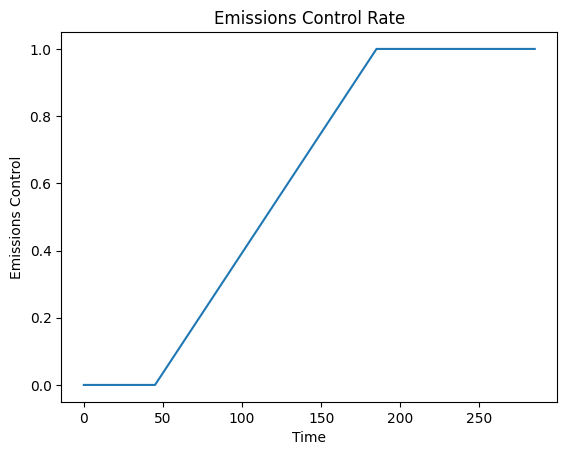

In [1]:
import pandas as pd
import numpy as np

from justice.util.data_loader import DataLoader
from justice.util.enumerations import *
from justice.util.model_time import TimeHorizon

# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.0 #0.0 #1.0
min_miu_year = 2060 #9-original #8 in this model  # 2060
max_miu = 1.0
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu


from matplotlib import pyplot as plt
plt.plot(emissions_control_rate[0, :])
plt.title("Emissions Control Rate")
plt.xlabel("Time")
plt.ylabel("Emissions Control")
plt.show()

## 1. JUSTICE Initialisation

JUSTICE Runs on 8 SSP-RCP scenarios. The SSP-RCP scenarios can be seen with this piece of code

In [2]:
# Get list of Scenarios from Enum

for idx, scenarios in enumerate(list(Scenario.__members__.keys())):
    print(idx, scenarios)

0 SSP119
1 SSP126
2 SSP245
3 SSP370
4 SSP434
5 SSP460
6 SSP534
7 SSP585


Here we initiate the model with a scenario index corresponding to a particular SSP-RCP scenario. The scenario index is from 0 to 7. The scenario index is the same as the index of the SSP-RCP scenarios in the list above.

The initialization phase of JUSTICE loads all the economic and climate data, creates all the arrays to store the results and sets the initial values of the variables.

In [3]:
from justice.model import JUSTICE
from justice.util.enumerations import *

# Instantiate the model
scenarios = 2
model = JUSTICE(
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
        social_welfare_function=WelfareFunction.LIMITARIAN_UTILITARIAN, #LIMITARIAN_UTILITARIAN,
        # climate_ensembles=570,
        climate_ensembles=[570, 235, 35, 980, 2], # OR just '570'. Takes Int and List @OPTIONAL: This is to select a specific climate ensemble or a list of ensemble
        stochastic_run=False, # @OPTIONAL: This is to run the FaIR model in stochastic mode. Default is True 
    )


/Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Run

The run function runs the model for a particular scenario index with the given policy lever setting. The run function returns the results of the simulation.


In [4]:
model.run(emission_control_rate = emissions_control_rate, endogenous_savings_rate=True) #savings_rate = fixed_savings_rate, 

## 3. Evaluate - SWF - and Generated Output Datasets

Evaluation Phase Extracts the results from the simulation and also applies the social welfare function to compute the welfare

In [5]:
datasets = model.evaluate() # Get the results of the simulation run

print(model.get_outcome_names()) # Get the list of outcomes from the simulation run

dict_keys(['gross_economic_output', 'net_economic_output', 'consumption', 'consumption_per_capita', 'damage_cost_per_capita', 'abatement_cost_per_capita', 'emissions', 'regional_temperature', 'global_temperature', 'damage_fraction', 'economic_damage', 'abatement_cost', 'carbon_price', 'states_aggregated_consumption_per_capita', 'spatially_aggregated_welfare', 'stepwise_marl_reward', 'temporally_disaggregated_welfare', 'welfare'])


## 3.1 Stepwise Run & Evaluate

Instead of running the entire model horizon, we can run the model step by step. This is useful for integrating the model with EMODPS framework for adaptive policymaking or RL framework.

In [6]:
for timestep in range(len(time_horizon.model_time_horizon)):
    
    model.stepwise_run( emission_control_rate = emissions_control_rate[:, timestep], timestep=timestep, endogenous_savings_rate=True) #savings_rate = fixed_savings_rate[:, timestep],
    datasets = model.stepwise_evaluate(timestep=timestep)
    


Extracting the data from the outcome dictionary to the different variables

In [6]:
#Load the data
gross_output = datasets['gross_economic_output'] 
net_output = datasets['net_economic_output']
consumption = datasets['consumption'] #(57, 286, 1001)
cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis_control = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)
states_aggregated_consumption_per_capita = datasets['states_aggregated_consumption_per_capita'] #(57, 286)
spatially_aggregated_welfare = datasets['spatially_aggregated_welfare'] # (286,)
temporally_disaggregated_welfare = datasets['temporally_disaggregated_welfare']  # (286,)
welfare = datasets['welfare'] # float
abatement_cost_per_capita = datasets["abatement_cost_per_capita"]
damage_cost_per_capita = datasets["damage_cost_per_capita"]


## 4. Visualize

We can visualize the timeseries of the different outcomes that we extracted in the previous step

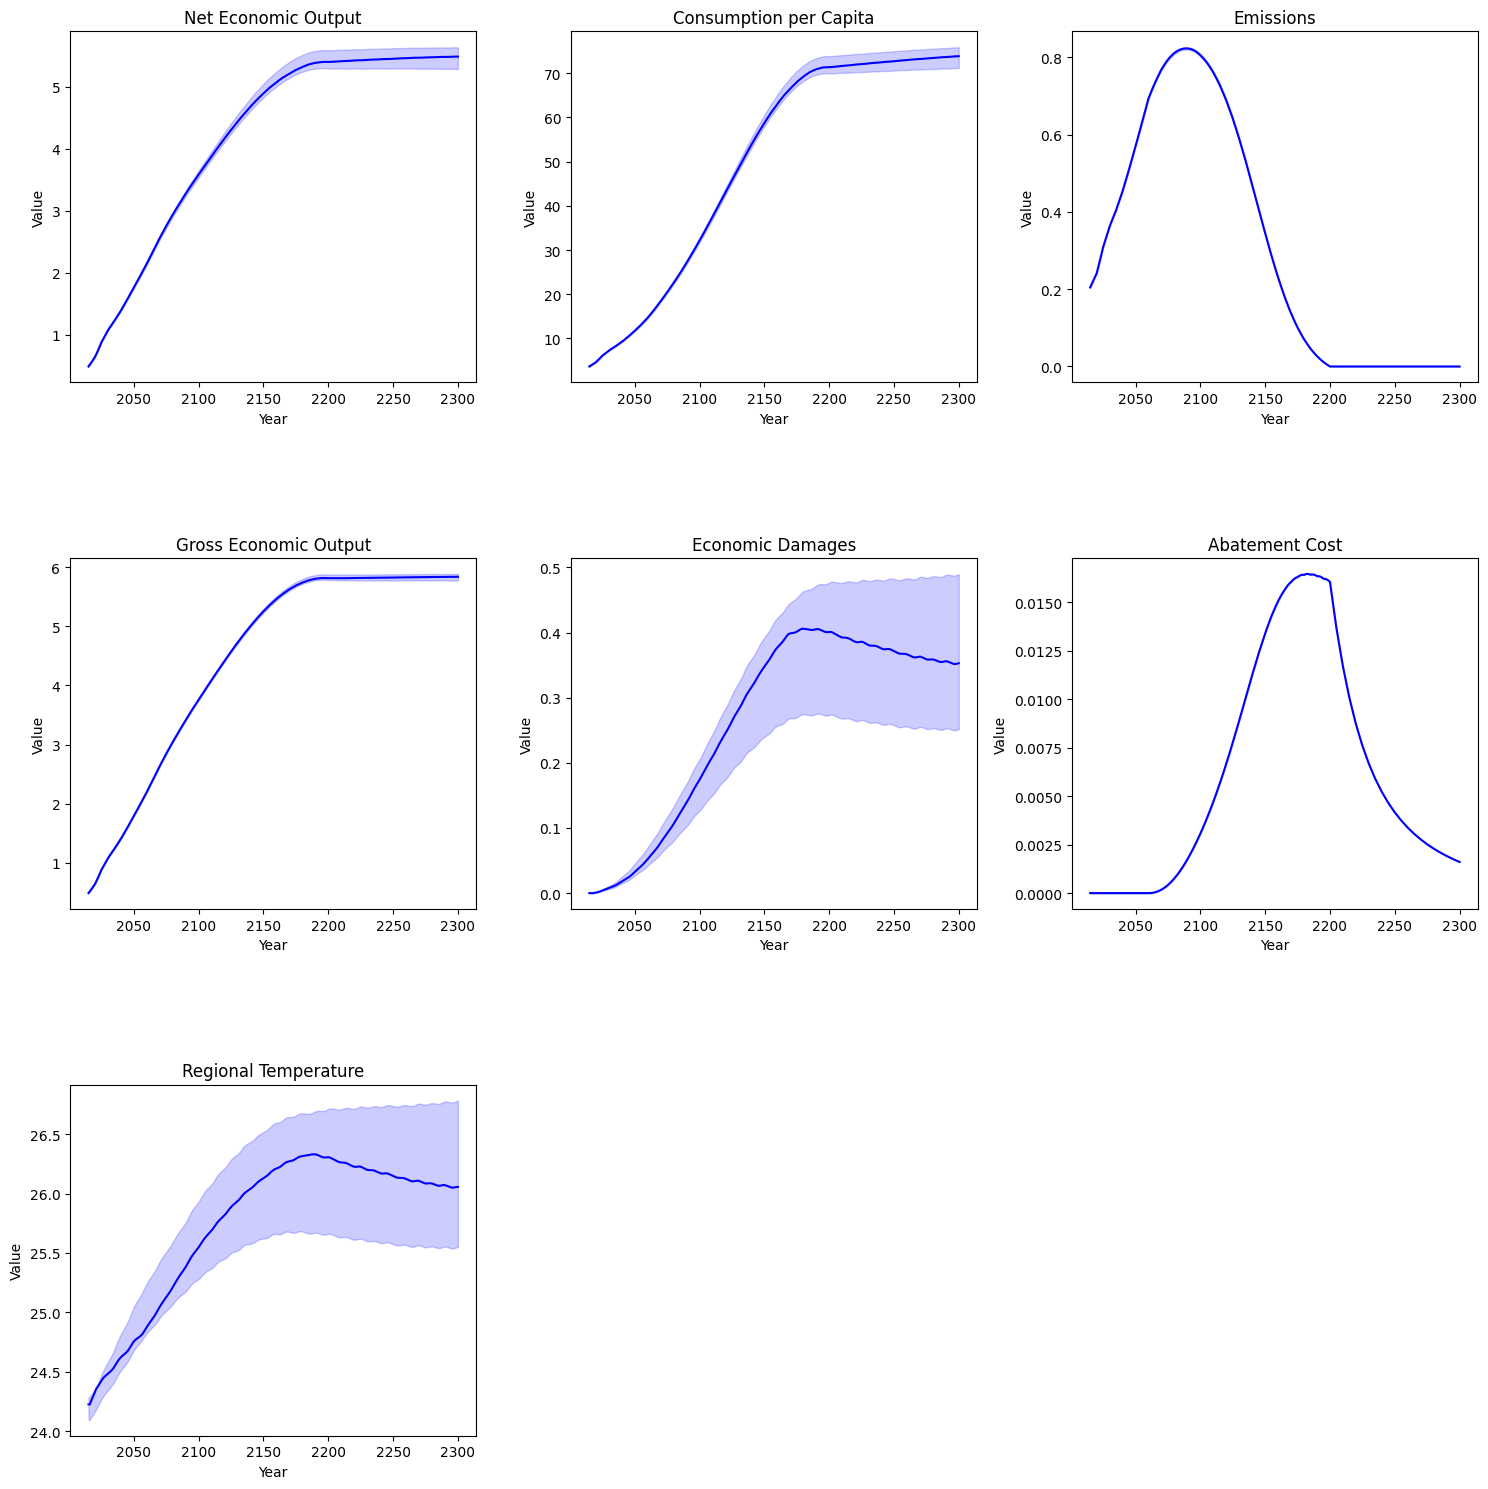

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create list of all the data arrays
data_list = [net_output, cpc, emis_control, gross_output, damages, abatecost, reg_temp]
titles = ['Net Economic Output', 'Consumption per Capita', 'Emissions', 'Gross Economic Output', 'Economic Damages', 'Abatement Cost', 'Regional Temperature']

region_index = 55

# Create a figure with 3 rows and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the data arrays and plot them
for i, loaded_data in enumerate(data_list):
    # Select the region based on region_index
    region_data = loaded_data[region_index, :, :]

    # Calculate the 5th, 50th (median), and 95th percentiles
    p5 = np.percentile(region_data, 5, axis=1)
    p50 = np.percentile(region_data, 50, axis=1)
    p95 = np.percentile(region_data, 95, axis=1)

    # Plot the envelope
    axs[i].fill_between(time_horizon.model_time_horizon, p5, p95, color='b', alpha=0.2)

    # Plot the median line
    sns.lineplot(x=time_horizon.model_time_horizon, y=p50, ax=axs[i], color='b')

    # Set the title and axis labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')

# Remove the unused subplots
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()





## 5. Model Reset Functionality

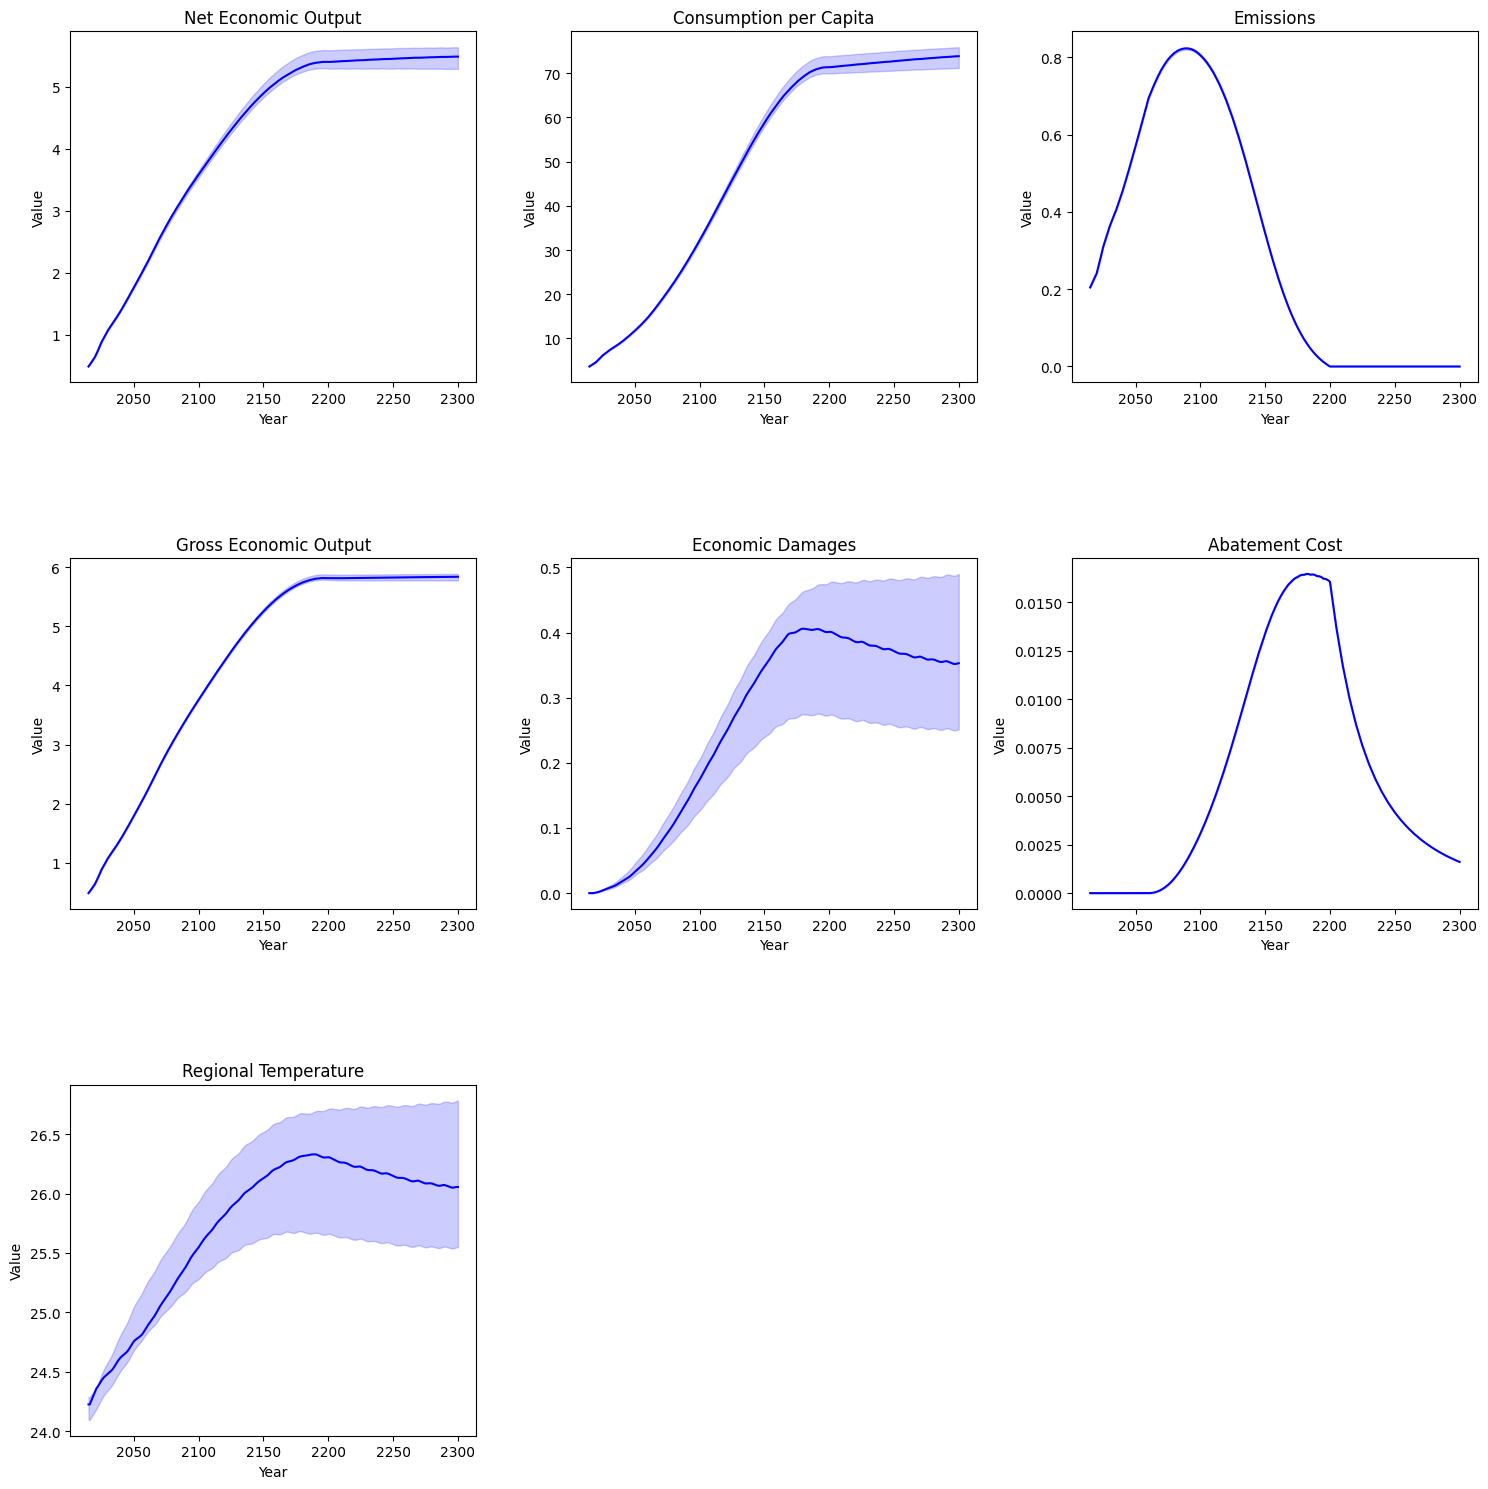

In [8]:
model.reset() # Reset the model to its initial state

model.run(emission_control_rate = emissions_control_rate, endogenous_savings_rate=True) #savings_rate = fixed_savings_rate, 
datasets = model.evaluate() # Get the results of the simulation run
#Load the data
gross_output = datasets['gross_economic_output'] 
net_output = datasets['net_economic_output']
consumption = datasets['consumption'] #(57, 286, 1001)
cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis_control = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)
states_aggregated_consumption_per_capita = datasets['states_aggregated_consumption_per_capita'] #(57, 286)
spatially_aggregated_welfare = datasets['spatially_aggregated_welfare'] # (286,)
temporally_disaggregated_welfare = datasets['temporally_disaggregated_welfare']  # (286,)
welfare = datasets['welfare'] # float
abatement_cost_per_capita = datasets["abatement_cost_per_capita"]
damage_cost_per_capita = datasets["damage_cost_per_capita"]



# Create list of all the data arrays
data_list = [net_output, cpc, emis_control, gross_output, damages, abatecost, reg_temp]
titles = ['Net Economic Output', 'Consumption per Capita', 'Emissions', 'Gross Economic Output', 'Economic Damages', 'Abatement Cost', 'Regional Temperature']

region_index = 55

# Create a figure with 3 rows and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the data arrays and plot them
for i, loaded_data in enumerate(data_list):
    # Select the region based on region_index
    region_data = loaded_data[region_index, :, :]

    # Calculate the 5th, 50th (median), and 95th percentiles
    p5 = np.percentile(region_data, 5, axis=1)
    p50 = np.percentile(region_data, 50, axis=1)
    p95 = np.percentile(region_data, 95, axis=1)

    # Plot the envelope
    axs[i].fill_between(time_horizon.model_time_horizon, p5, p95, color='b', alpha=0.2)

    # Plot the median line
    sns.lineplot(x=time_horizon.model_time_horizon, y=p50, ax=axs[i], color='b')

    # Set the title and axis labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')

# Remove the unused subplots
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()





## Run All Scenarios

In [5]:
# Create a dictionary to store the data for each scenario
scenario_data = {}


for idx, scenarios in enumerate(list(Scenario.__members__.keys())):
    print(idx, scenarios)
    
    # Initialize the model
    model = JUSTICE(
            scenario =idx,
            economy_type=Economy.NEOCLASSICAL,
            damage_function_type=DamageFunction.KALKUHL,
            abatement_type=Abatement.ENERDATA,
            social_welfare_function=WelfareFunction.UTILITARIAN,
        )
    
    # Run the model
    model.run(emission_control_rate = emissions_control_rate, endogenous_savings_rate=True)


    # Evaluate the model
    scenario_data[scenarios] = model.evaluate()


0 SSP119
1 SSP126
2 SSP245
3 SSP370
4 SSP434
5 SSP460
6 SSP534
7 SSP585


## Reproducing the Plots from Paper

# ______________________________________________________________________________________________________________________

## 1. Optimization of JUSTICE

This code generates the Pareto-optimal candidate policies based on the objectives. The output is a tar.gz containing the solutions (weights, center, radii of the RBF). This output will be used in the next step to generate the reference set from different seeds and to compute hypervolume.

In [1]:
from analysis.analyzer import run_optimization_adaptive
import numpy as np
import random
from justice.util.enumerations import Optimizer
# Set the seed for reproducibility

seeds = [
    9845531,
    1644652,
    3569126,
    6075612,
    521475,
]
seed = seeds[4]
random.seed(seed)
np.random.seed(seed)
config_path = 'analysis/limitarian_opt_config.json' # This loads the config used in the Paper
run_optimization_adaptive(config_path = config_path,
                          swf=0, # 0 for utilitarian, 1 for prioritarian etc. See enumeration.py
                          nfe=10, # Small number for demonstration
                          population_size=2, # Small number for demonstration. Usually the default value is 100
                          seed=seed,
                          datapath = "./data",
                          optimizer=Optimizer.BorgMOEA, 
                          )

11it [01:12,  6.56s/it]                                                        


## Generating Reference Set & Calculating Hypervolume

In [19]:
# This code creates a reference set from the different seeds

from solvers.convergence.hypervolume import get_global_reference_set, calculate_hypervolume_from_archives
import multiprocessing
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
temporary_data_saving_path = "data/temporary"
list_of_objectives = [
    "welfare",
    "years_above_temperature_threshold",
    "welfare_loss_damage",
    "welfare_loss_abatement",
]
data_path = "data/optimized_rbf_weights/150k/UTIL"  # NOTE: Change this according to the Rival Framing's folder name

direction_of_optimization = ["min", "min", "max", "max"]

get_global_reference_set(
    list_of_objectives=list_of_objectives,
    data_path=data_path,
    file_name=None,
    swf=[
        "UTILITARIAN",
        # "PRIORITARIAN",
        # "EGALITARIAN",
        # "SUFFICIENTARIAN",
    ],
    nfe="150000", # Ran for 150k number of function evaluations

    # Setting the same epsilon values as optimization process  (see analysis/analyzer.py)
    epsilons=[
        0.1,
        0.25,
        10,
        10,
    ],
    direction_of_optimization=direction_of_optimization,
    output_data_path=temporary_data_saving_path,
    saving=True,
)

## This computes the Hypervolume for the reference set

filenames = [
    # Loading Archives for the different seeds for UTILITARIAN
    "UTILITARIAN_150000_521475.tar.gz",
    "UTILITARIAN_150000_1644652.tar.gz",
    "UTILITARIAN_150000_3569126.tar.gz",
    "UTILITARIAN_150000_6075612.tar.gz",
    "UTILITARIAN_150000_9845531.tar.gz",

    # Loading Archives for the different seeds for PRIORITARIAN
    # "PRIORITARIAN_150000_521475.tar.gz",
    # "PRIORITARIAN_150000_1644652.tar.gz",
    # "PRIORITARIAN_150000_3569126.tar.gz",
    # "PRIORITARIAN_150000_6075612.tar.gz",
    # "PRIORITARIAN_150000_9845531.tar.gz",


]

reference_set = "UTILITARIAN_reference_set.csv"
with multiprocessing.Pool() as pool:
    # Enumerate through the filenames
    for filename in filenames:
        scores = calculate_hypervolume_from_archives(
            list_of_objectives=list_of_objectives,
            direction_of_optimization=direction_of_optimization,
            input_data_path=data_path,
            file_name=filename,
            output_data_path=temporary_data_saving_path,
            saving=True,
            global_reference_set=True,
            global_reference_set_path=temporary_data_saving_path,
            global_reference_set_file=reference_set,
            pool=pool,
          )  # NOTE: Change this according to the PF refset

Loading list of files
Loading archives for  UTILITARIAN
UTILITARIAN_150000_9845531.tar.gz
Loading archives for  UTILITARIAN_150000_9845531.tar.gz
Max key:  150266
Number of rows:  105
Archives loaded
UTILITARIAN_150000_521475.tar.gz
Loading archives for  UTILITARIAN_150000_521475.tar.gz
Max key:  150369
Number of rows:  98
Archives loaded
UTILITARIAN_150000_6075612.tar.gz
Loading archives for  UTILITARIAN_150000_6075612.tar.gz
Max key:  150280
Number of rows:  119
Archives loaded
UTILITARIAN_150000_1644652.tar.gz
Loading archives for  UTILITARIAN_150000_1644652.tar.gz
Max key:  150373
Number of rows:  101
Archives loaded
UTILITARIAN_150000_3569126.tar.gz
Loading archives for  UTILITARIAN_150000_3569126.tar.gz
Max key:  150064
Number of rows:  110
Archives loaded
Reference set saved to data/temporary/UTILITARIAN_reference_set.csv
Loading archives for  UTILITARIAN_150000_521475.tar.gz
Archives loaded
list_of_archives:  (14393, 4)
reference_set (106, 4)
type of reference_set <class 'numpy

/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25

Time taken for Hypervolume Calculation: 2.147 seconds
data/temporary/UTILITARIAN_150000_521475_hv.csv
Loading archives for  UTILITARIAN_150000_1644652.tar.gz
Archives loaded
list_of_archives:  (11948, 4)
reference_set (106, 4)
type of reference_set <class 'numpy.ndarray'>
nfes: 
 [100, 100774, 102086, 10246, 103398, 104710, 106022, 107334, 108646, 109958, 1100, 111270, 112582, 113894, 115206, 11558, 116518, 117830, 119142, 120454, 121766, 123078, 124390, 125702, 127014, 128326, 12870, 129638, 130950, 132262, 133574, 134886, 136198, 137510, 138822, 140134, 141446, 14182, 142689, 144045, 145401, 146757, 148113, 149469, 150373, 15494, 16806, 18118, 19430, 20742, 2100, 22054, 23366, 24678, 25990, 27302, 28614, 29926, 3100, 31238, 32550, 33862, 35174, 36486, 37798, 39110, 40422, 4100, 41734, 43046, 44358, 45670, 46982, 48294, 49606, 50918, 5100, 52230, 53542, 54854, 56166, 57478, 58790, 60102, 6100, 61414, 62726, 64038, 65350, 66662, 67974, 69286, 70598, 7100, 71910, 73222, 74534, 75846, 77

In [ ]:
from justice.util.visualizer import plot_hypervolume

temporary_data_saving_path = "data/convergence_metrics" #"data/temporary" #data/convergence_metrics
input_data_path_list = {
    
     "UTILITARIAN": ["UTILITARIAN_150000_521475_hv.csv", "UTILITARIAN_150000_1644652_hv.csv", 'UTILITARIAN_150000_3569126_hv.csv', 'UTILITARIAN_150000_6075612_hv.csv', 'UTILITARIAN_150000_9845531_hv.csv'],
     "PRIORITARIAN": ["PRIORITARIAN_150000_521475_hv.csv", "PRIORITARIAN_150000_1644652_hv.csv", 'PRIORITARIAN_150000_3569126_hv.csv', 'PRIORITARIAN_150000_6075612_hv.csv', 'PRIORITARIAN_150000_9845531_hv.csv'],
     "EGALITARIAN": ["EGALITARIAN_150000_521475_hv.csv", "EGALITARIAN_150000_1644652_hv.csv", 'EGALITARIAN_150000_3569126_hv.csv', 'EGALITARIAN_150000_6075612_hv.csv', 'EGALITARIAN_150000_9845531_hv.csv'],
     "SUFFICIENTARIAN": ["SUFFICIENTARIAN_150000_521475_hv.csv", "SUFFICIENTARIAN_150000_1644652_hv.csv", 'SUFFICIENTARIAN_150000_3569126_hv.csv', 'SUFFICIENTARIAN_150000_6075612_hv.csv', 'SUFFICIENTARIAN_150000_9845531_hv.csv'],

}


fig = plot_hypervolume(
    path_to_data=temporary_data_saving_path,
    path_to_output="./data/plots/convergence_plots",
    input_data=input_data_path_list,
    yaxis_upper_limit=0.7,
    width=1000,
    height=800,
    fontsize=20,
    saving=True,
)

fig.show()

# Visualizing the Trade-offs

Min and Max values of the objectives ['welfare_utilitarian', 'welfare_prioritarian', 'years_above_temperature_threshold']
welfare_utilitarian                  103.49622
welfare_prioritarian                 410.33239
years_above_temperature_threshold     84.98002
dtype: float64
welfare_utilitarian                  103.840020
welfare_prioritarian                 413.448952
years_above_temperature_threshold    244.927073
dtype: float64


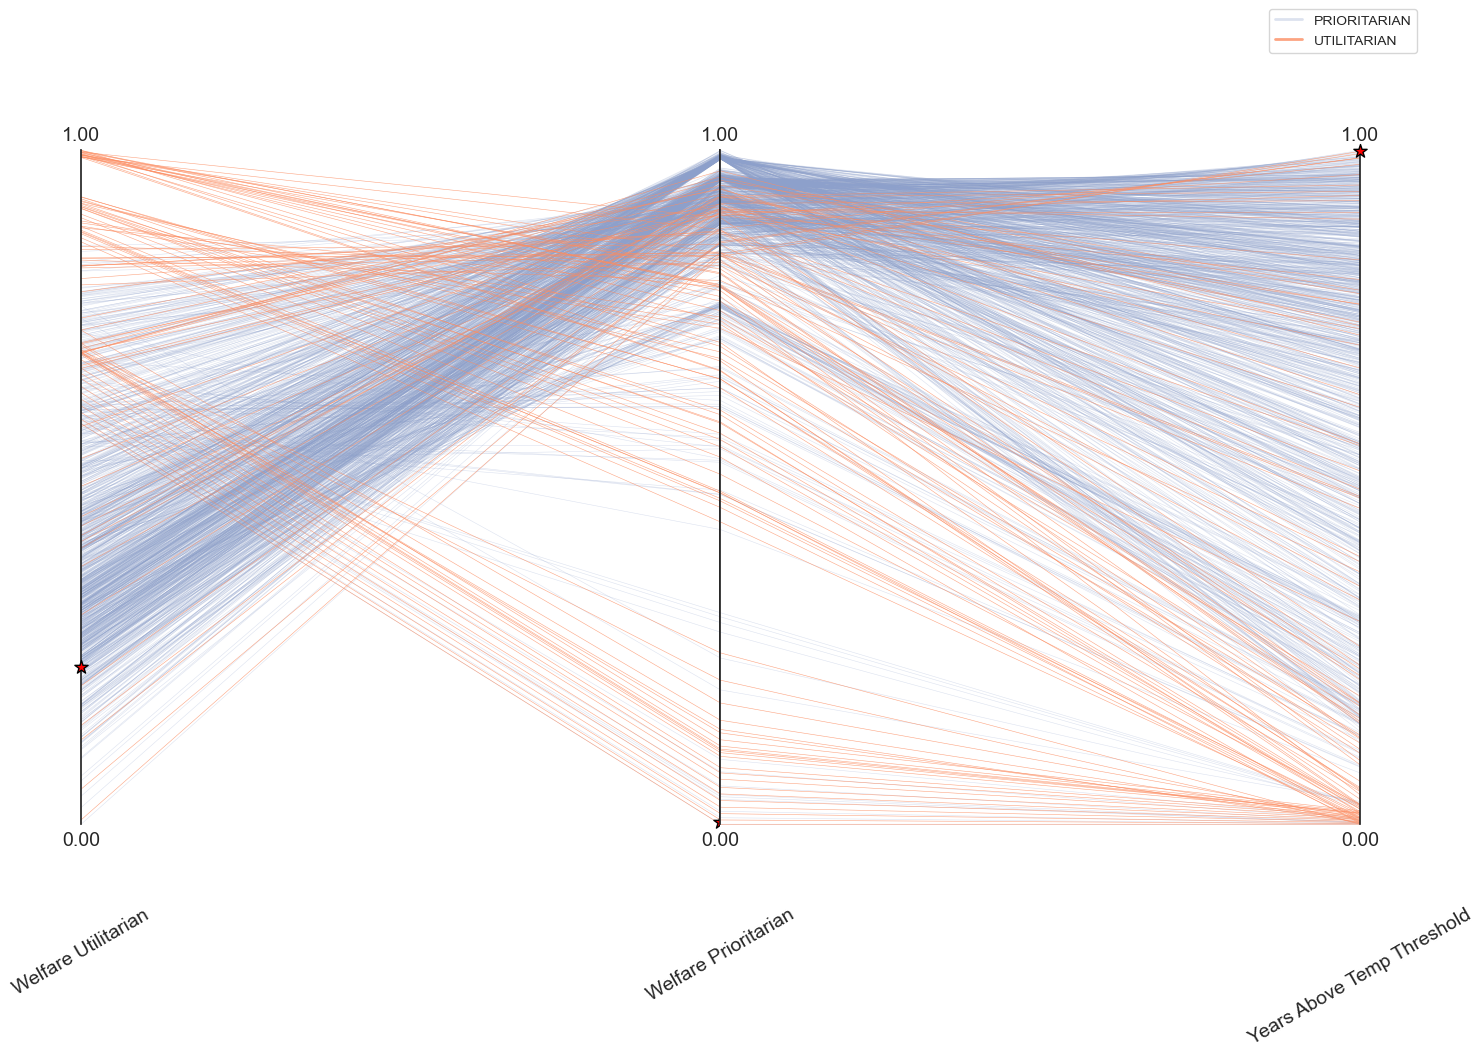

In [ ]:
# visualize_tradeoffs_with_annotations

from justice.util.visualizer import visualize_tradeoffs_with_annotations

# Example Usage
concatenated_df = visualize_tradeoffs_with_annotations(
    path_to_data="data/temporary",
    
input_data=[
    "PRIORITARIAN_reference_set_reevaluated.csv",
    "UTILITARIAN_reference_set_reevaluated.csv",
    
],
objective_of_interest="welfare_utilitarian",

default_colors=[(141/255, 160/255, 203/255, 0.3), (252/255, 141/255, 98/255, 0.8)],

list_of_objectives=[
    "welfare_utilitarian",
    "welfare_prioritarian",
    "years_above_temperature_threshold",
    # "damage_cost_per_capita_utilitarian",
    # "damage_cost_per_capita_prioritarian",
    # "abatement_cost_per_capita_utilitarian",
    # "abatement_cost_per_capita_prioritarian",
],
direction_of_optimization=[

    "min",
    "min",
    "min",
    # "max",
    # "max",
    # "max",
],
pretty_labels=[
    # "Welfare",
    "Welfare Utilitarian",
    "Welfare Prioritarian",
    "Years Above Temp Threshold",
    # "Welfare Loss Damage Utilitarian",
    # "Welfare Loss Damage Prioritarian",
    # "Welfare Loss Abatement Utilitarian",
    # "Welfare Loss Abatement Prioritarian",
],
show_best_solutions=False,
temperature_filter=False,
alpha=None,
show_legend=True,
saving=True,
fontsize=14,
scaling=True,
path_to_output="./data/plots/only_welfare_temp",
# New parameter: annotation values. For example, we will annotate only the first three axes.
annotate_values=[103.76, 413.44, 85.2], # Coinciding objective values of utilitarian and prioritarian

)




# Filtering Pareto Optimal Solutions 

### Filtering Pareto Optimal Solutions - 10% best performing solutions. Next, use the selected policy lever to run the model and evaluate the outcomes

In [ ]:
import pandas as pd
from justice.util.output_data_processor import reevaluate_optimal_policy, get_selected_policy_indices_based_on_welfare_temperature, reevaluated_optimal_policy_variable_extractor
from justice.util.model_time import TimeHorizon
from justice.util.data_loader import DataLoader

# selected_indices = get_selected_policy_indices_based_on_welfare_temperature(
#     rival_framings=[
#         # "UTILITARIAN",
#         # "PRIORITARIAN",
#         # "SUFFICIENTARIAN",
#         "EGALITARIAN",
#     ],
#     data_dir="data/convergence_metrics",
#     n_percent=0.1, # 10% of the data
# )
# print(selected_indices)
# ############################################################################################################
scenario_list = ["SSP245"]
start_year = 2015
end_year = 2300
data_timestep = 5
timestep = 1

data_loader = DataLoader()
region_list = data_loader.REGION_LIST

# Set the time horizon
time_horizon = TimeHorizon(
    start_year=start_year,
    end_year=end_year,
    data_timestep=data_timestep,
    timestep=timestep,
)

list_of_years = time_horizon.model_time_horizon

# NOTE: The following code generates large dataframes and saved them in the data/temporary folder. Size is ~ 1.5 GB each run
reevaluate_optimal_policy(
    input_data=[
        # "UTILITARIAN_reference_set.csv",
        # "PRIORITARIAN_reference_set.csv",
        # "SUFFICIENTARIAN_reference_set.csv",
        # "EGALITARIAN_reference_set.csv",
        "UTILITARIAN_reference_set_reevaluated.csv",
        # "PRIORITARIAN_reference_set_reevaluated.csv",
    ],
    path_to_rbf_weights="data/temporary/",  #  reevaluation
    path_to_output="data/temporary/",
    direction_of_optimization=[
        "min",
        "min",
        "max",
        "max",
    ],
    rbf_policy_index= 73, #selected_indices[0], # This chooses policy for a particular rival framing. Can also set to the index directly
    list_of_objectives=[
        "welfare",
        "years_above_temperature_threshold",
        "welfare_loss_damage",
        "welfare_loss_abatement",
    ],
    scenario_list=scenario_list,  
)



index for policy:  73
2 SSP245
Welfare:  103.83778671185836
Keys of the scenario data:  dict_keys(['SSP245'])
File saved as UTILITARIAN_reference_set_reevaluated_idx73 at location data/temporary/


In [ ]:
import pandas as pd
from justice.util.output_data_processor import reevaluate_optimal_policy, get_selected_policy_indices_based_on_welfare_temperature, reevaluated_optimal_policy_variable_extractor
from justice.util.model_time import TimeHorizon
from justice.util.data_loader import DataLoader


scenario_list = ["SSP245"]
start_year = 2015
end_year = 2300
data_timestep = 5
timestep = 1

data_loader = DataLoader()
region_list = data_loader.REGION_LIST

# Set the time horizon
time_horizon = TimeHorizon(
    start_year=start_year,
    end_year=end_year,
    data_timestep=data_timestep,
    timestep=timestep,
)

list_of_years = time_horizon.model_time_horizon




############################################################################################################
reevaluated_optimal_policy_variable_extractor(
    scenario_list=scenario_list,  # ['SSP245'],
    region_list=region_list,
    list_of_years=list_of_years,
    path_to_data="data/temporary", 
    path_to_output="data/temporary",  
    variable_name="constrained_emission_control_rate", #"constrained_emission_control_rate", #"emissions",  # "net_economic_output",  # "economic_damage",  # "emissions", #abatement_cost, # "global_temperature", gross_economic_output, consumption_per_capita
    data_shape=3, # 2 for temperature, 3 for rest
    no_of_ensembles=1001,
    input_data=[
        # Main Set for analysis - 10% Welfare
        # "UTILITARIAN_reference_set_idx16.h5",
        # "PRIORITARIAN_reference_set_idx196.h5",
        # "SUFFICIENTARIAN_reference_set_idx57.h5",
        # "EGALITARIAN_reference_set_idx404.h5",

        # Comparing extreme and coinciding solutions
        # "UTILITARIAN_reference_set_reevaluated_idx14.h5",
        "PRIORITARIAN_reference_set_reevaluated_idx685.h5",

        # "UTILITARIAN_reference_set_reevaluated_idx77.h5",
        # "PRIORITARIAN_reference_set_reevaluated_idx478.h5",
        

        # "UTILITARIAN_reference_set_reevaluated_idx73.h5",
        # "PRIORITARIAN_reference_set_reevaluated_idx397.h5",


    ],
    output_file_names=[
        # "Utilitarian",
        "Prioritarian",
        # "Sufficientarian",
        # "Egalitarian",

    ],
)




Directory:  /Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE
SSP245
File saved as Prioritarian_idx685_SSP245_constrained_emission_control_rate at location data/temporary


'\nwelfare_utilitarian value:\nindex pairs: [(14, 685)]\n\n\nwelfare_prioritarian value:\nindex pairs: [(77, 478)]\n\nyears_above_temperature_threshold:\nIndex pairs: [(73, 397)]\n\n'